In [55]:
# ------------------------------------------
# a. Import Required Libraries
# ------------------------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, UpSampling1D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
#------------------------------------------
# b. Load and Preprocess ECG CSV Data
# ------------------------------------------

csv_path = "/Users/mayur/Downloads/DL for AI/ecg-csv/ecg.csv"
df = pd.read_csv(csv_path)

# Assuming CSV structure: first column = labels, others = signal values
labels = df.iloc[:, 0].values          # label column
signals = df.iloc[:, 1:].values        # all ECG signal samples

# Normalize signal between 0 and 1
signals = signals.astype("float32")
signals = (signals - signals.min()) / (signals.max() - signals.min())

# Train-test split
split_index = int(0.8 * len(signals))
x_train = signals[:split_index]
x_test = signals[split_index:]

y_train = labels[:split_index]
y_test = labels[split_index:]

# Add channel dimension for Conv1D
x_train = np.expand_dims(x_train, axis=-1)   # shape: (N, timesteps, 1)
x_test  = np.expand_dims(x_test, axis=-1)

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)


Train shape: (3997, 140, 1)
Test shape: (1000, 140, 1)


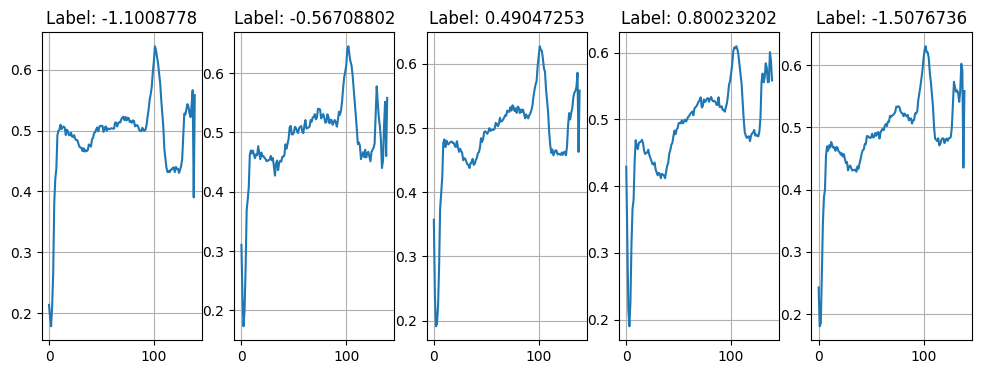

In [57]:
plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(x_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.grid(True)
plt.show()


In [58]:
# ------------------------------------------
# c. Build Encoder (1D)
# ------------------------------------------

input_signal = Input(shape=(x_train.shape[1], 1))

# Encoder
x = Conv1D(32, 3, activation='relu', padding='same')(input_signal)
x = MaxPooling1D(2, padding='same')(x)

x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)

# Latent space
latent = Conv1D(128, 3, activation='relu', padding='same')(x)

encoder = Model(input_signal, latent, name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 140, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 140, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 70, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 70, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 35, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 35, 128)        │        24,704 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,040 (121.25 KB)

 Trainable params: 31,040 (121.25 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# ------------------------------------------
# d. Build Decoder
# ------------------------------------------

decoder_input = Input(shape=latent.shape[1:])

y = Conv1D(64, 3, activation='relu', padding='same')(decoder_input)
y = UpSampling1D(2)(y)

y = Conv1D(32, 3, activation='relu', padding='same')(y)
y = UpSampling1D(2)(y)

decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(y)

decoder = Model(decoder_input, decoded, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 35, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 35, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 70, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 70, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 140, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 140, 1)         │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,913 (120.75 KB)

 Trainable params: 30,913 (120.75 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# ------------------------------------------
# e. Autoencoder Model
# ------------------------------------------

encoded = encoder(input_signal)
decoded = decoder(encoded)

autoencoder = Model(input_signal, decoded)

In [61]:
# Compile model
autoencoder.compile(
    optimizer=Adam(),
    loss='mse'
)

In [62]:
# ------------------------------------------
# Train Autoencoder
# ------------------------------------------

history = autoencoder.fit(
    x_train,
    x_train,
    epochs=15,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test, x_test)
)


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1467e-04 - val_loss: 4.0319e-04
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6316e-04 - val_loss: 1.4976e-04
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5803e-04 - val_loss: 1.3676e-04
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3277e-04 - val_loss: 9.3783e-05
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0089e-04 - val_loss: 8.1851e-05
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0730e-04 - val_loss: 7.9489e-05
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5665e-05 - val_loss: 5.3480e-05
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.1785e-05 - val_loss: 4.4940e-05
Epoch 10/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2230e-05 - val_loss: 4.1477e-05
Epoch 11/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4767e-05 - val_loss: 4.02

In [63]:
# ------------------------------------------
# Anomaly Detection
# ------------------------------------------

reconstructed = autoencoder.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [64]:
# Per-sample MAE
error_per_sample = np.mean(np.abs(x_test - reconstructed), axis=(1,2))

# Threshold = 95th percentile of normal samples
threshold = np.percentile(error_per_sample, 95)

print("Anomaly threshold:", threshold)

# Flag anomalies
anomalies = error_per_sample > threshold
print("Anomalies detected:", np.sum(anomalies))

Anomaly threshold: 0.006968995882198214
Anomalies detected: 50


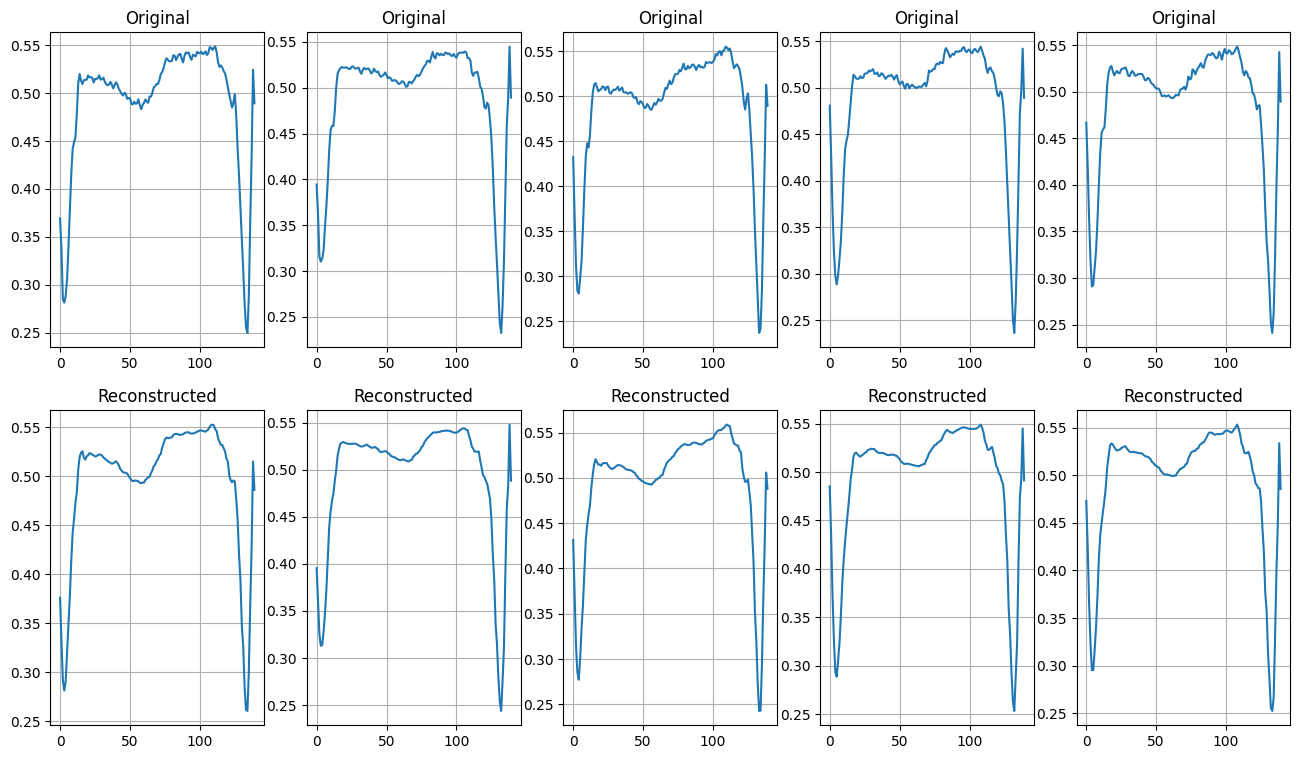

In [65]:
# ------------------------------------------
# Visualize Original vs Reconstructed
# ------------------------------------------
plt.figure(figsize=(16,9))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.plot(x_test[i])
    plt.title("Original")
    plt.grid(True)

    plt.subplot(2,5,i+1+5)
    plt.plot(reconstructed[i])
    plt.title("Reconstructed")
    plt.grid(True)

plt.show()
